In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'giant_otter'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [54]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=20000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 20,
    min_level_db = -50,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
)

In [55]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

In [56]:
np.unique([i.data['samplerate_hz'] for i in list(dataset.data_files.values())])

array([48000, 96000])

In [57]:
# dataset.data_files = {i:dataset.data_files[i] for i in list(dataset.data_files.keys())[:5]}

In [58]:
dataset.sample_json

OrderedDict([('fid', 'S287'),
             ('species', 'Pteronura brasiliensis'),
             ('common_name', 'Giant otter'),
             ('samplerate_hz', 96000),
             ('original_wav',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/raw/otter/zip_contents/Audio S287_isolation call.wav'),
             ('length_s', 1.2139166666666668),
             ('wav_loc',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/raw/otter/zip_contents/Audio S287_isolation call.wav'),
             ('indvs',
              OrderedDict([('UNK',
                            OrderedDict([('syllables',
                                          OrderedDict([('start_times', [0.0]),
                                                       ('end_times',
                                                        [1.2139166666666668]),
                                                       ('labels',
                                                        ['isolation ca

In [59]:
len(dataset.data_files)

453

#### Create dataset based upon JSON

In [60]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [61]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=["labels"],
            unit="syllables",
            dict_features_to_retain = [],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0219s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.2s


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  38 out of 453 | elapsed:    0.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  84 out of 453 | elapsed:    0.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done 453 out of 453 | elapsed:    0.9s finished


453

In [62]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,key
0,0.0,1.213917,isolation call,UNK,0,Audio_S287_isolation_call
0,0.0,0.737667,close call,UNK,0,Audio_S105_close_call
0,0.0,1.098792,suckling call,UNK,0,Audio_S450_suckling_call


### get audio for dataset

In [63]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 453 out of 453 | elapsed:    3.1s finished


453

In [64]:
df_mask  = np.array([len(i) > 0 for i in tqdm(syllable_df.audio.values)])

In [65]:
syllable_df = syllable_df[np.array(df_mask)]

In [66]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,key,audio,rate
0,0.0,1.213917,isolation call,UNK,0,Audio_S287_isolation_call,"[-9.965951363416249e-06, -5.47231269318542e-05...",96000
0,0.0,0.737667,close call,UNK,0,Audio_S105_close_call,"[-1.4237073376308926e-06, 6.724563958393518e-0...",96000
0,0.0,1.098792,suckling call,UNK,0,Audio_S450_suckling_call,"[-2.8474146752617853e-06, -1.5025018835830818e...",96000


In [67]:
sylls = syllable_df.audio.values

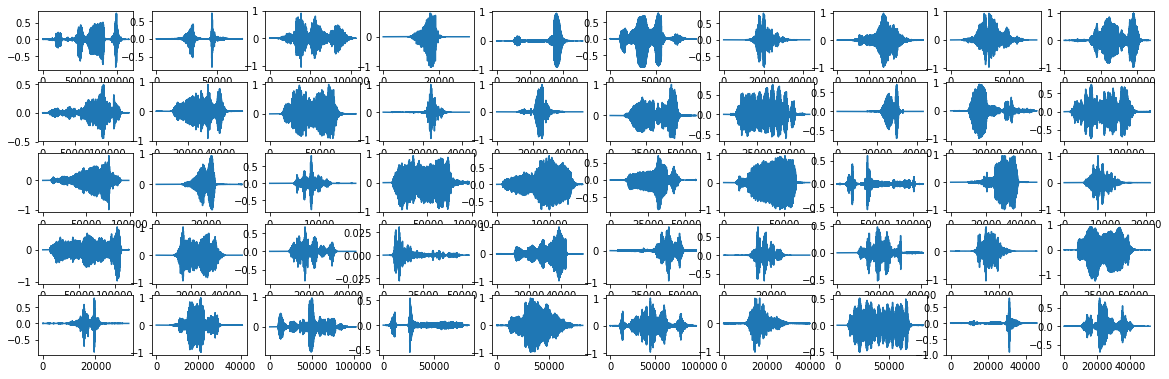

In [68]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

In [69]:
syllable_df['audio'] = [i/np.max(i) for i in syllable_df.audio.values]

### Create spectrograms

In [70]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [71]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [72]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0351s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s


[Parallel(n_jobs=-1)]: Done 268 out of 453 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 453 out of 453 | elapsed:    1.2s finished


### Rescale spectrogram
- using log rescaling

In [73]:
log_scaling_factor = 4

In [74]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0079s.) Setting batch_size=50.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0079s.) Setting batch_size=2526.


[Parallel(n_jobs=-1)]: Done 453 out of 453 | elapsed:    0.5s finished


(25.0, 10) (320, 800) 25.0 32 800


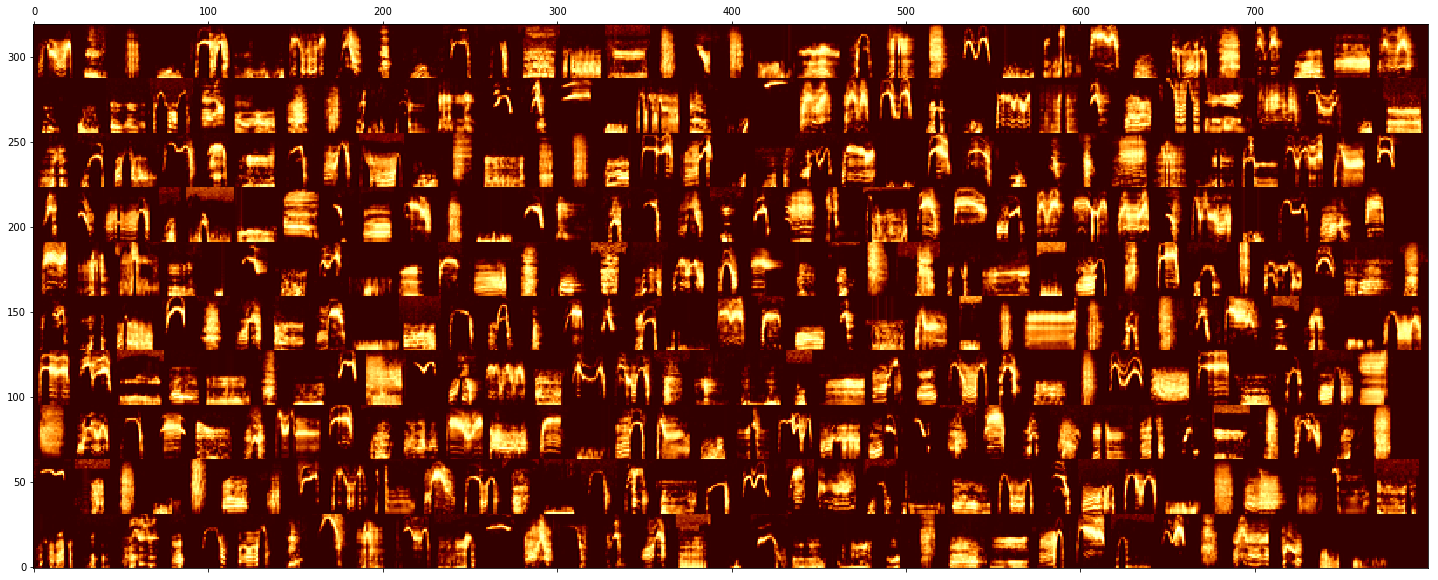

In [75]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [76]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [77]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,key,audio,rate
0,0.0,1.213917,isolation call,UNK,0,Audio_S287_isolation_call,"[-1.2798290802061346e-05, -7.027552779787061e-...",96000
0,0.0,0.737667,close call,UNK,0,Audio_S105_close_call,"[-1.9724764766160915e-06, 9.316552547592764e-0...",96000
0,0.0,1.098792,suckling call,UNK,0,Audio_S450_suckling_call,"[-3.1328436848193265e-06, -1.653114868834354e-...",96000


In [78]:
import seaborn as sns

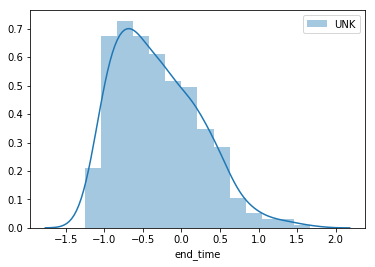

In [79]:
for indv in np.unique(syllable_df.indv):
    sns.distplot(np.log(syllable_df[syllable_df.indv==indv]["end_time"]), label=indv)
plt.legend()

In [80]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0210s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0210s.) Setting batch_size=342.
[Parallel(n_jobs=-1)]: Done 453 out of 453 | elapsed:    0.2s finished


(25.0, 10) (320, 800) 25.0 32 800


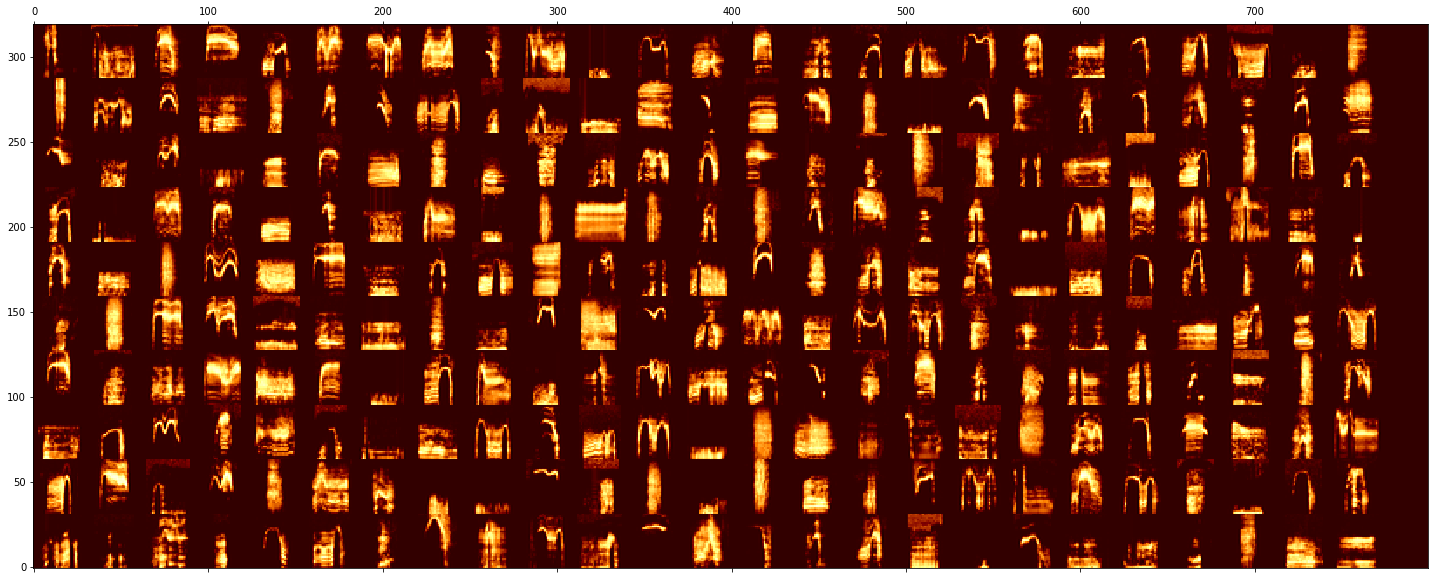

In [81]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [82]:
np.shape(syllables_spec)

(453, 32, 31)

In [83]:
syllable_df['spectrogram'] = syllables_spec

In [84]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,key,audio,rate,spectrogram
0,0.0,1.213917,isolation call,UNK,0,Audio_S287_isolation_call,"[-1.2798290802061346e-05, -7.027552779787061e-...",96000,"[[0.0, 0.0, 0.0, 0.0028829596, -0.009689297, 0..."
0,0.0,0.737667,close call,UNK,0,Audio_S105_close_call,"[-1.9724764766160915e-06, 9.316552547592764e-0...",96000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 2.2376324e-05, -0.0..."
0,0.0,1.098792,suckling call,UNK,0,Audio_S450_suckling_call,"[-3.1328436848193265e-06, -1.653114868834354e-...",96000,"[[0.0, 0.0, 0.0, 0.0, 0.00026210205, 0.0034825..."


In [88]:
len(syllable_df)

453

### view syllables per indv

In [100]:
label_freq = pd.DataFrame({labels:[sum(syllable_df.labels == labels)] for labels in np.sort(syllable_df.labels.unique())}).T.sort_values(by=0, ascending=False)
label_freq.T

,begging scream,snort,contact call,hum,begging scream gradation,growl,hum gradation,Ascending scream,contact call gradation,bark,...,underwater call,contact call like,Distress call 1,hum gradation like,hum like,low whistle,begging call like,bark like,Distress call 2,high whistle
0,32,32,32,30,30,29,29,25,25,21,...,9,2,1,1,1,1,1,1,1,1


In [85]:
syllable_df.indv.unique()

array(['UNK'], dtype=object)

Ascending scream 25
(50.0, 2) (32, 800) 25.0 32 800


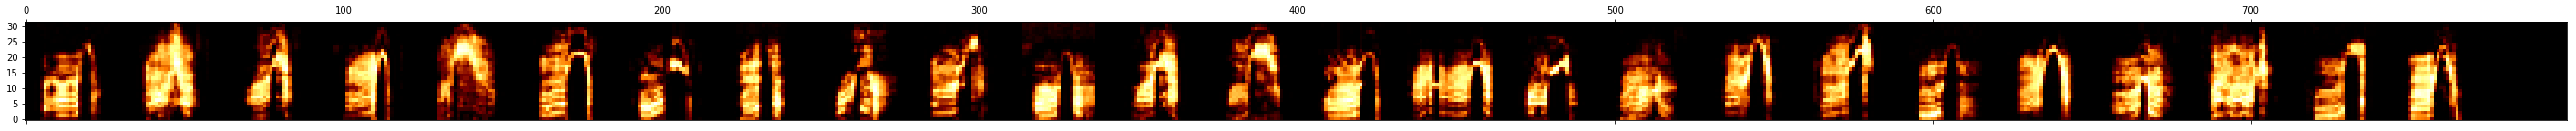

Distress call 1 1
(50.0, 2) (32, 800) 25.0 32 800


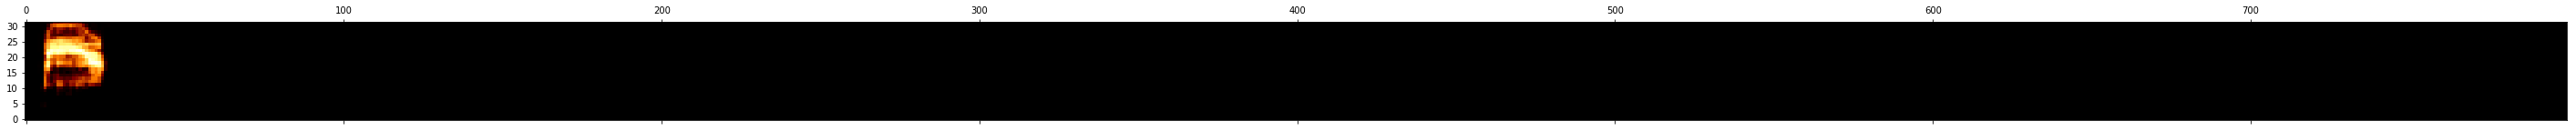

Distress call 2 1
(50.0, 2) (32, 800) 25.0 32 800


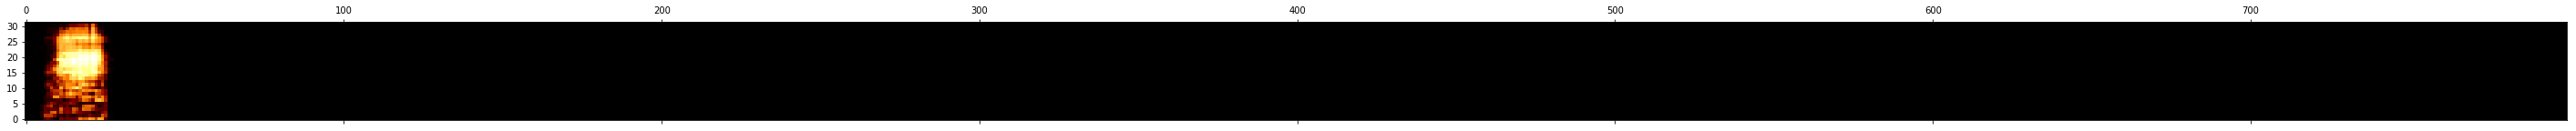

bark 21
(50.0, 2) (32, 800) 25.0 32 800


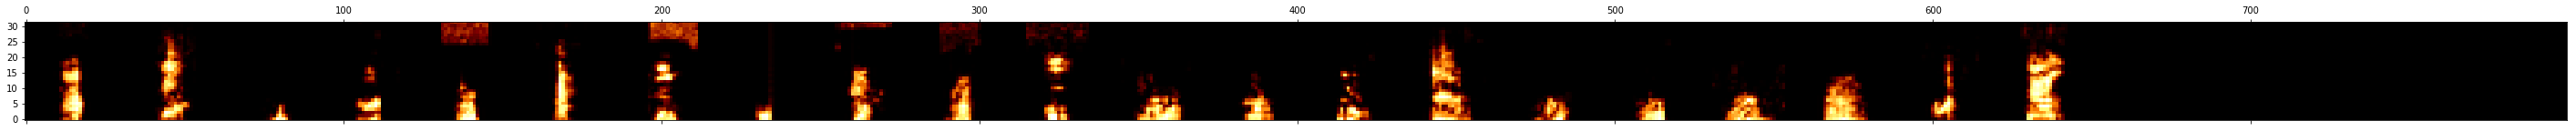

bark like 1
(50.0, 2) (32, 800) 25.0 32 800


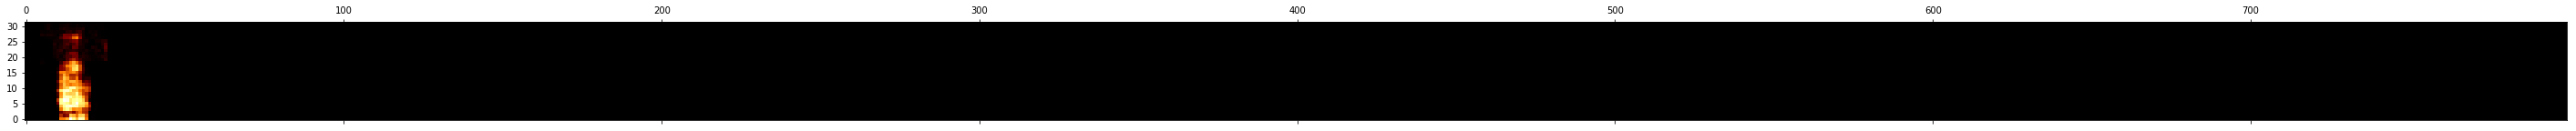

begging call 21
(50.0, 2) (32, 800) 25.0 32 800


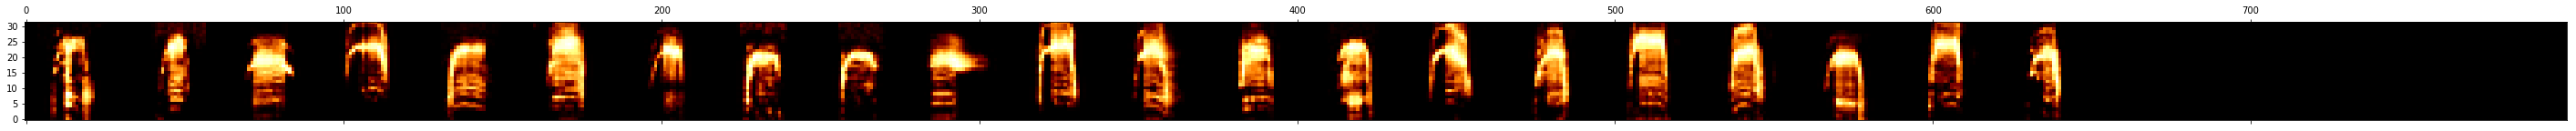

begging call like 1
(50.0, 2) (32, 800) 25.0 32 800


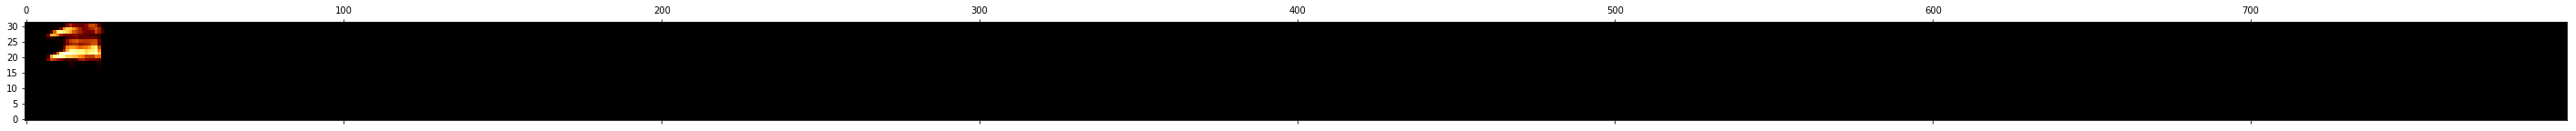

begging scream 32
(50.0, 4) (64, 800) 25.0 32 800


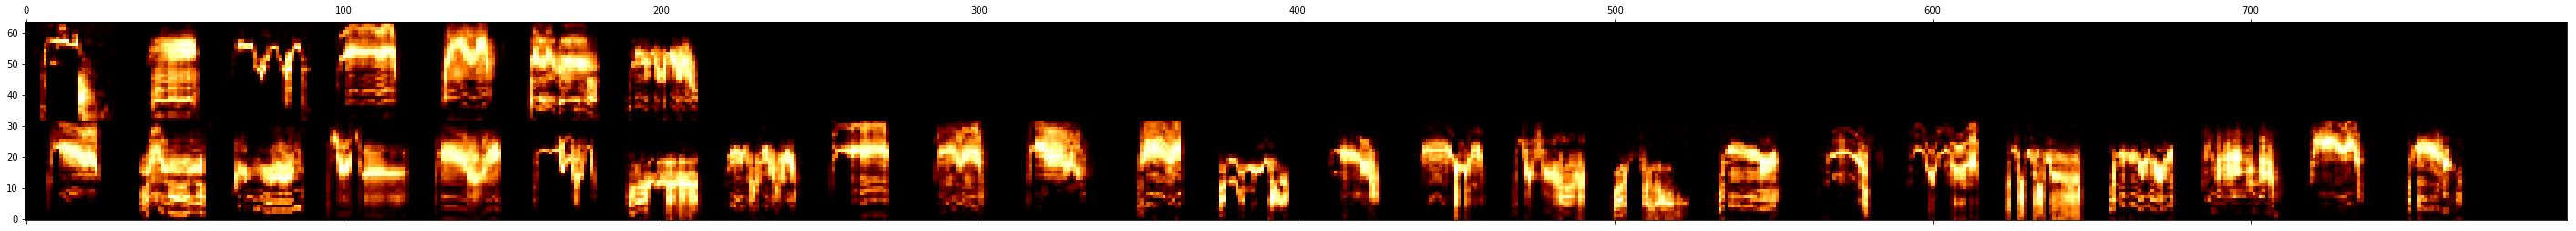

begging scream gradation 30
(50.0, 4) (64, 800) 25.0 32 800


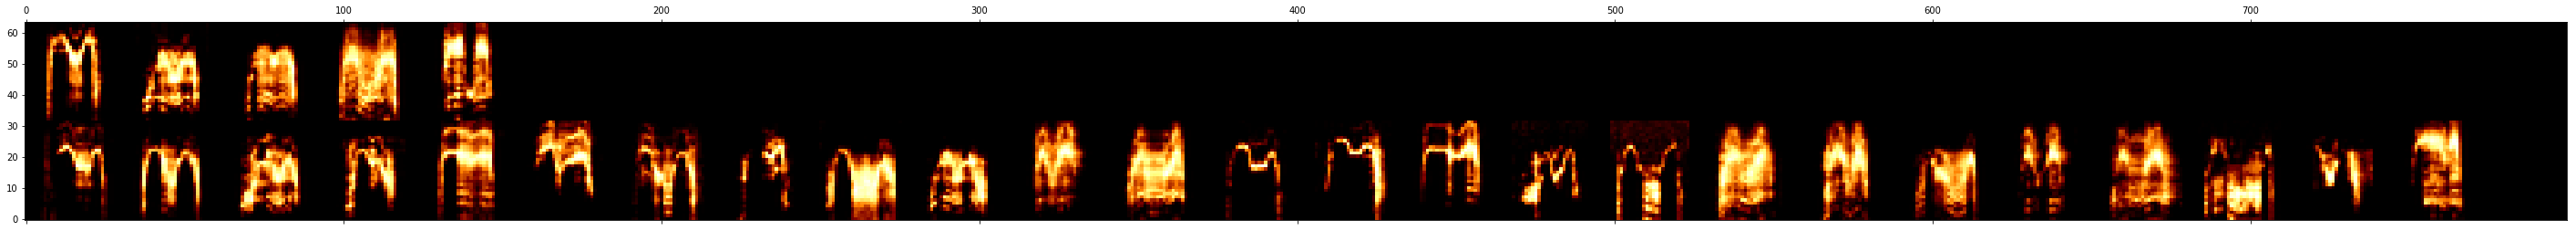

close call 10
(50.0, 2) (32, 800) 25.0 32 800


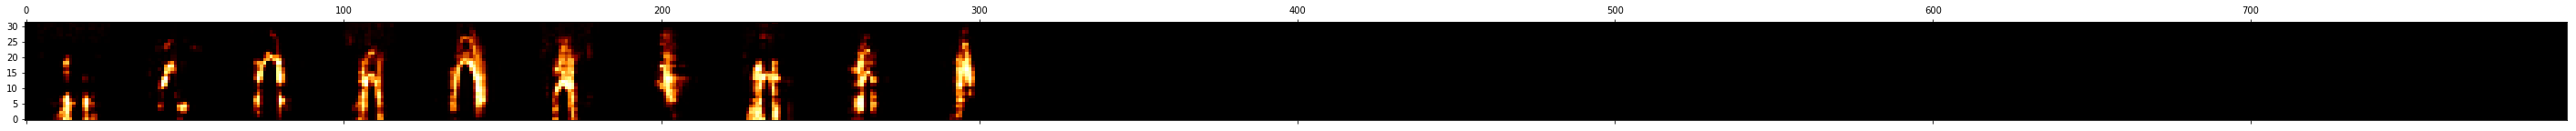

contact call 32
(50.0, 4) (64, 800) 25.0 32 800


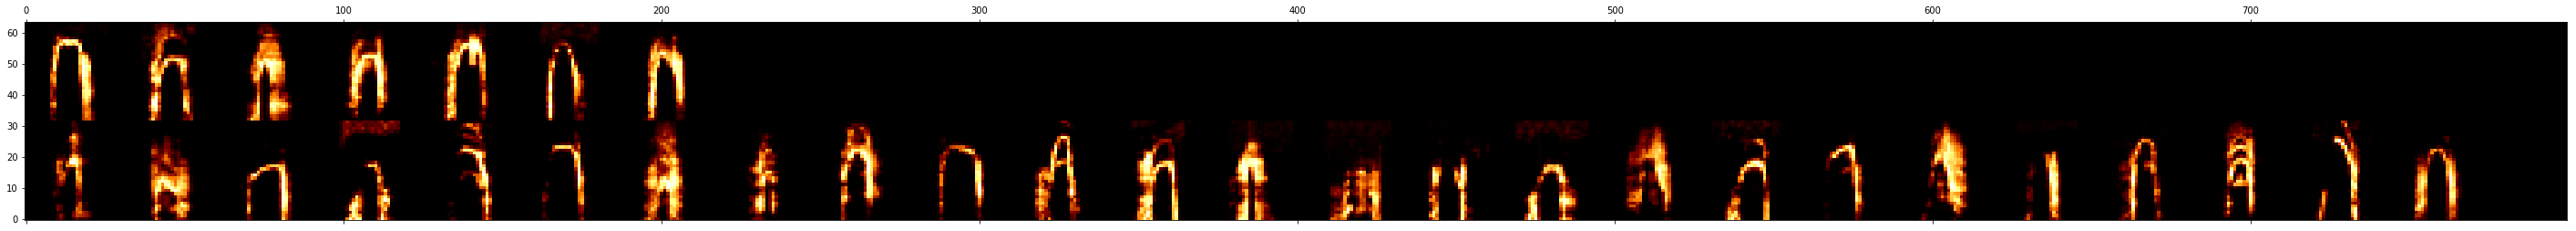

contact call gradation 25
(50.0, 2) (32, 800) 25.0 32 800


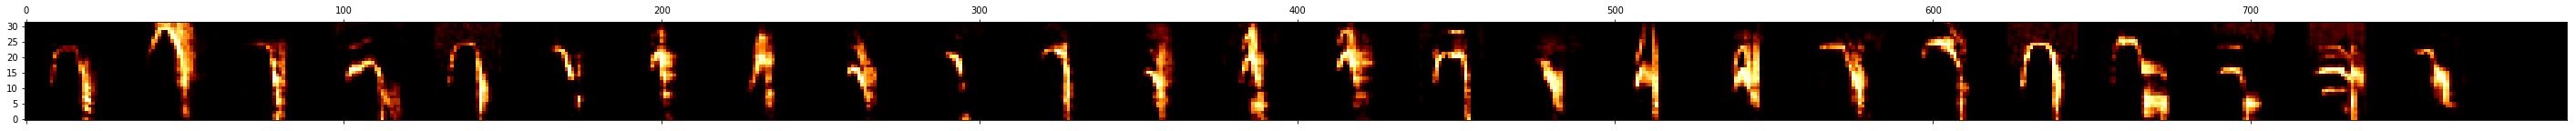

contact call like 2
(50.0, 2) (32, 800) 25.0 32 800


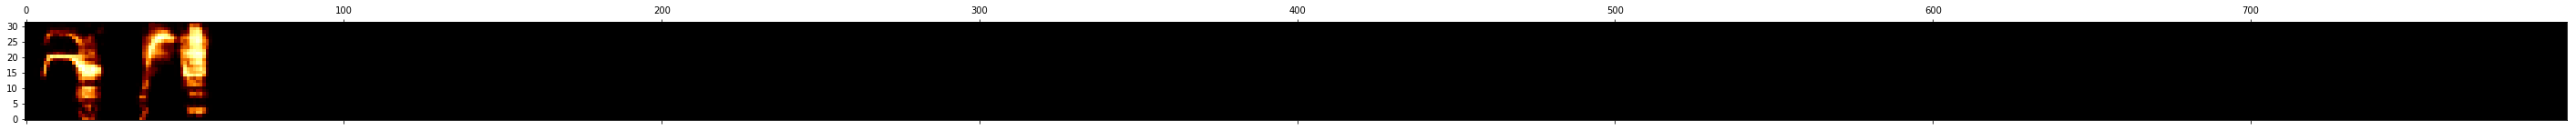

growl 29
(50.0, 4) (64, 800) 25.0 32 800


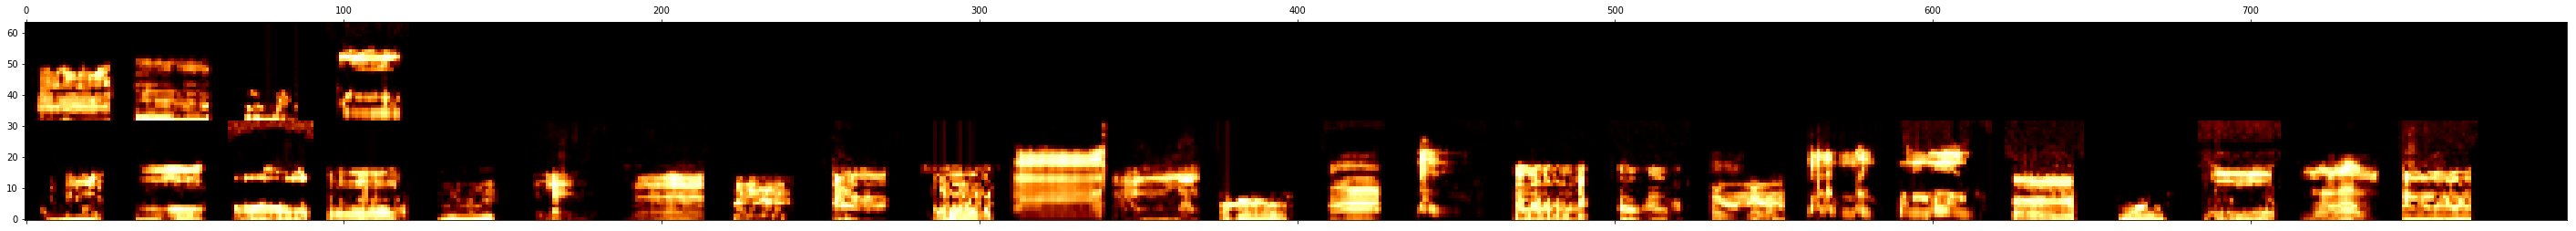

hah 17
(50.0, 2) (32, 800) 25.0 32 800


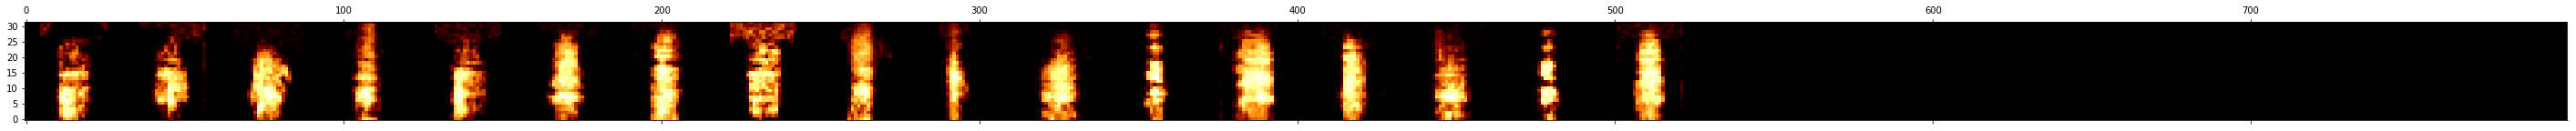

high whistle 1
(50.0, 2) (32, 800) 25.0 32 800


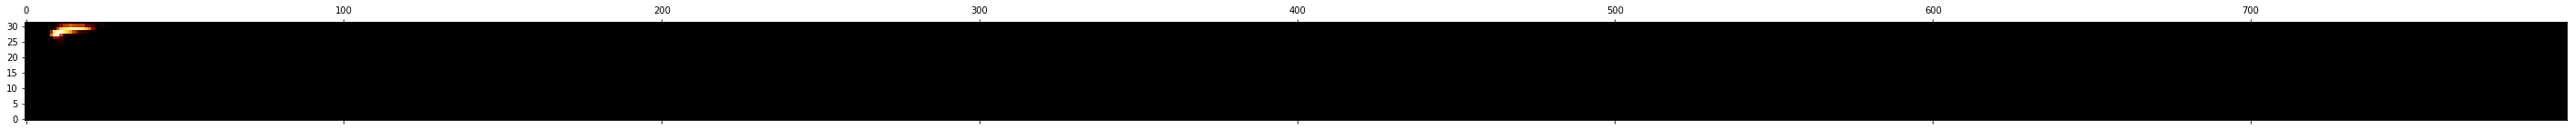

hum 30
(50.0, 4) (64, 800) 25.0 32 800


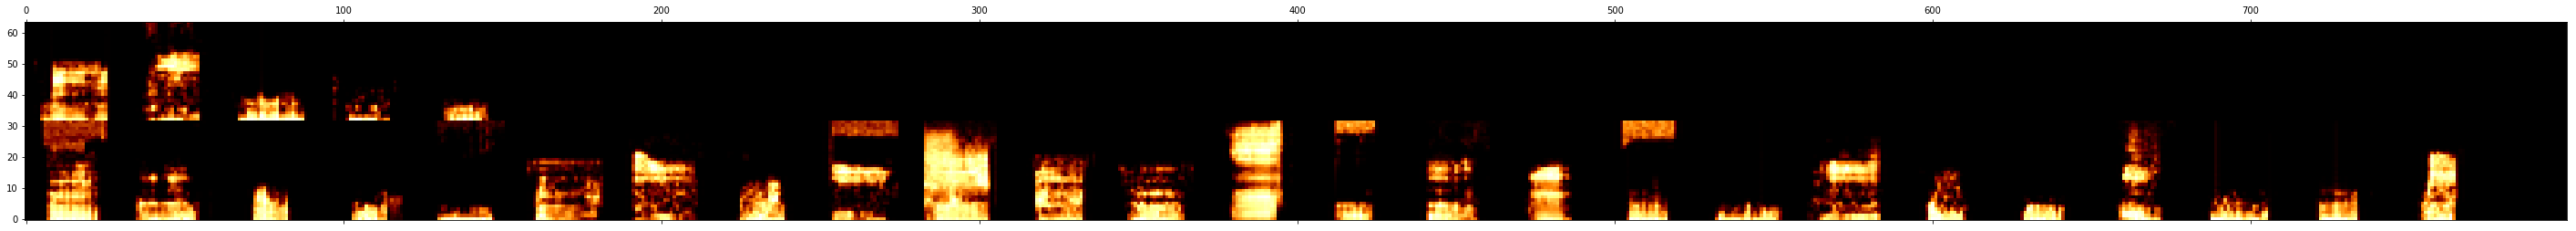

hum gradation 29
(50.0, 4) (64, 800) 25.0 32 800


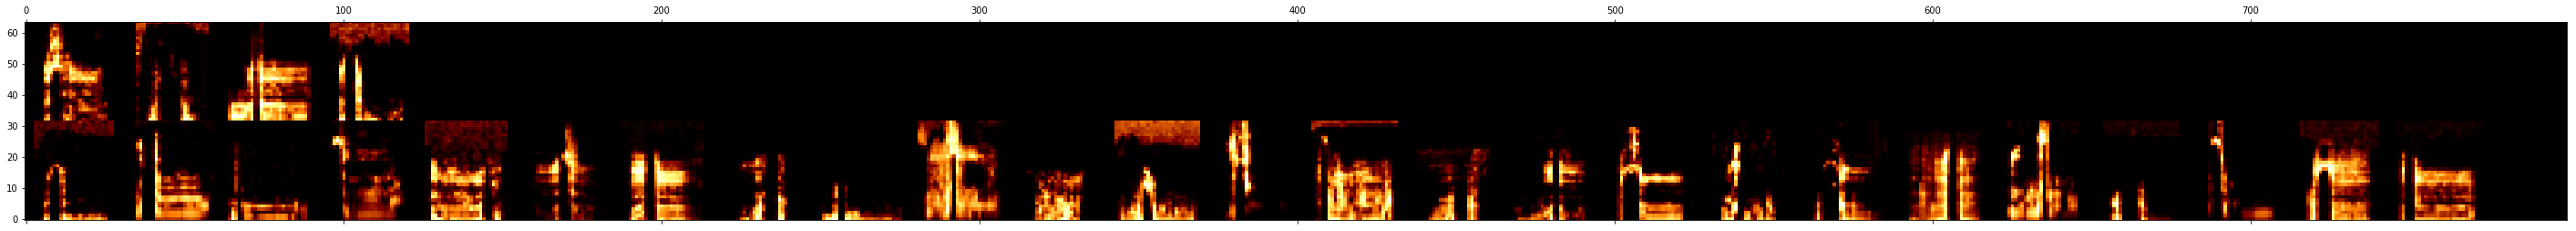

hum gradation like 1
(50.0, 2) (32, 800) 25.0 32 800


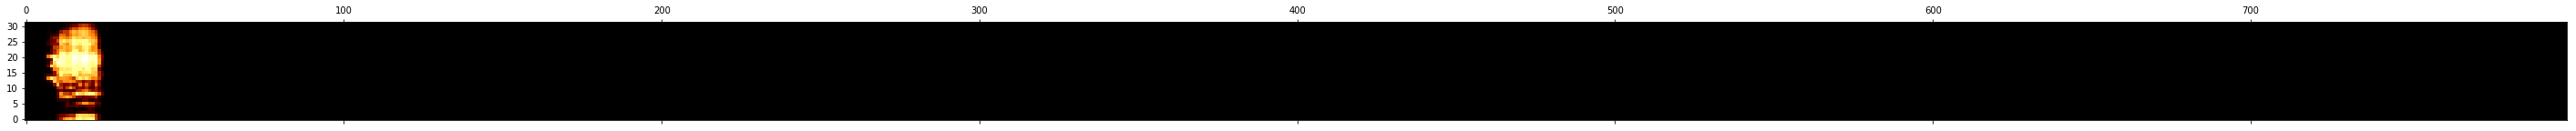

hum like 1
(50.0, 2) (32, 800) 25.0 32 800


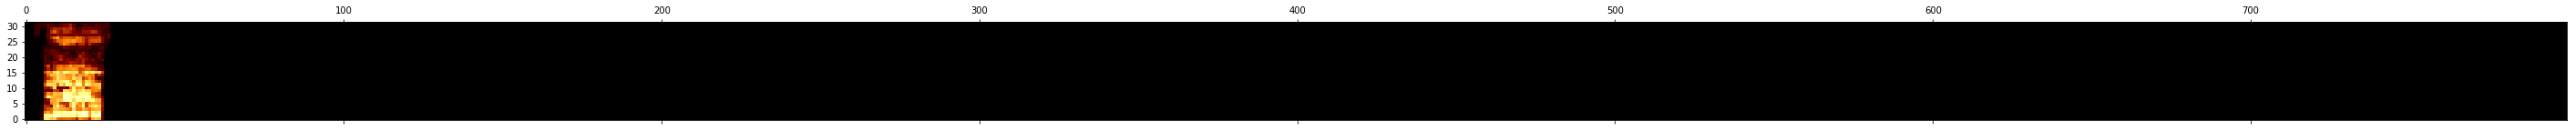

hum short 9
(50.0, 2) (32, 800) 25.0 32 800


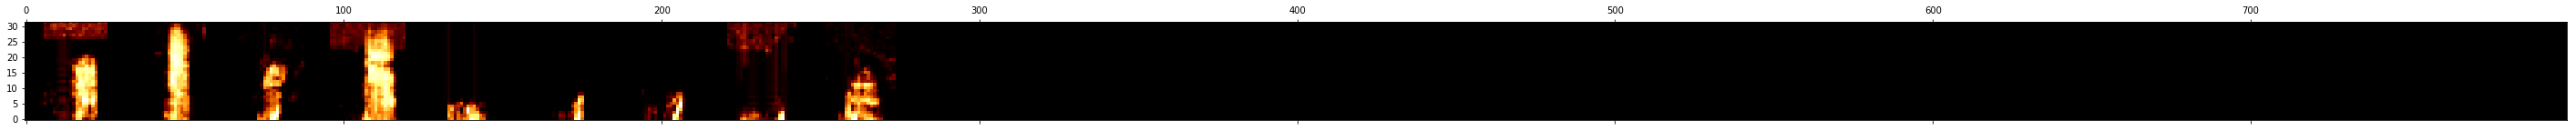

isolation call 16
(50.0, 2) (32, 800) 25.0 32 800


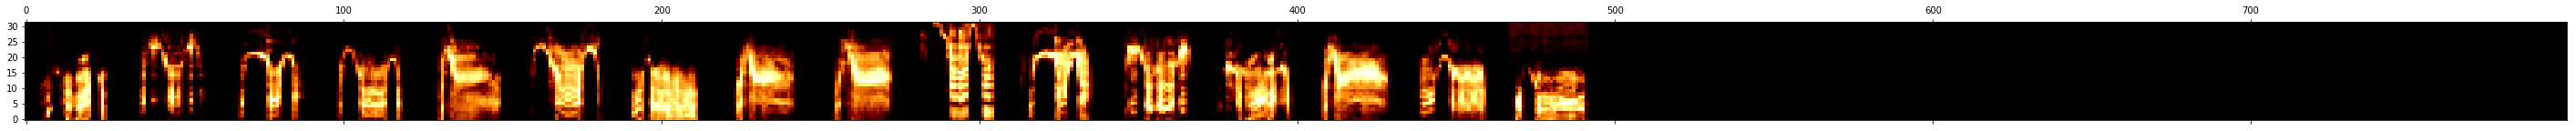

low whistle 1
(50.0, 2) (32, 800) 25.0 32 800


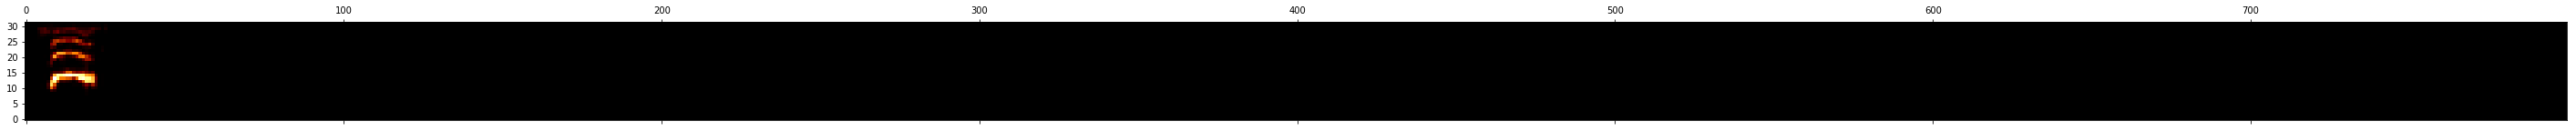

snort 32
(50.0, 4) (64, 800) 25.0 32 800


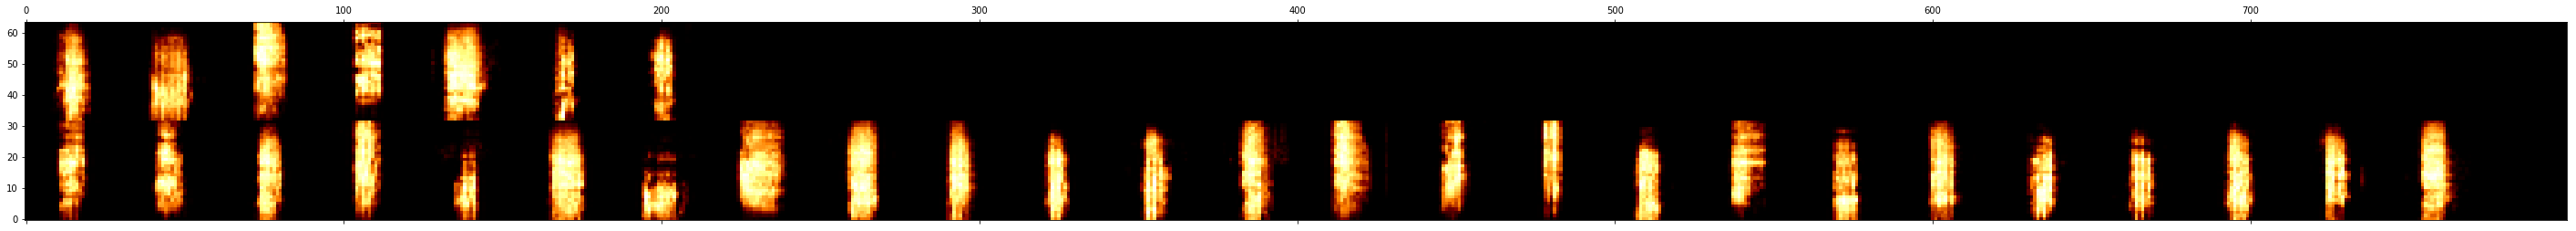

suckling call 13
(50.0, 2) (32, 800) 25.0 32 800


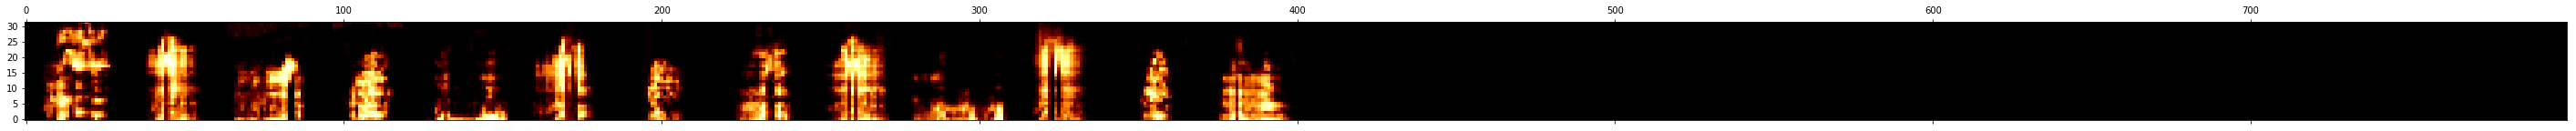

underwater call 9
(50.0, 2) (32, 800) 25.0 32 800


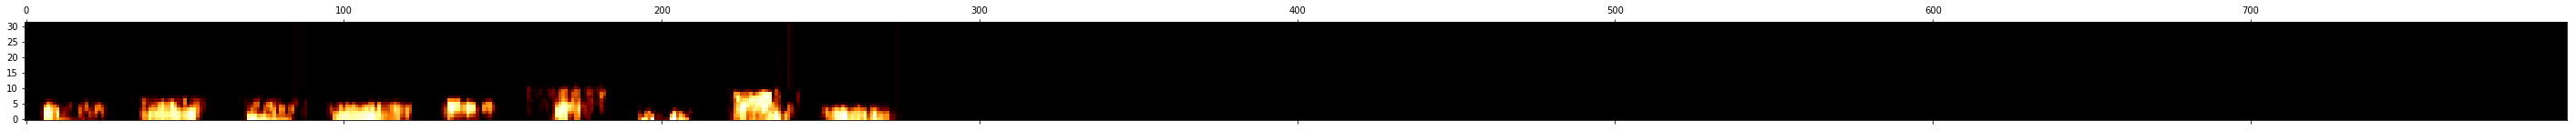

wavering scream 11
(50.0, 2) (32, 800) 25.0 32 800


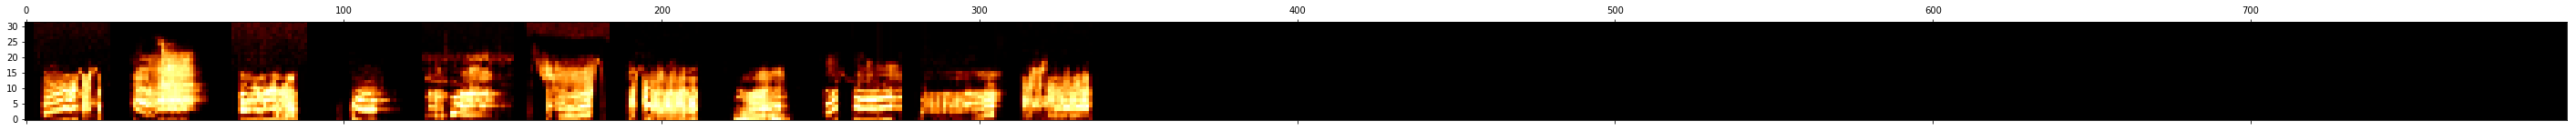

whine 20
(50.0, 2) (32, 800) 25.0 32 800


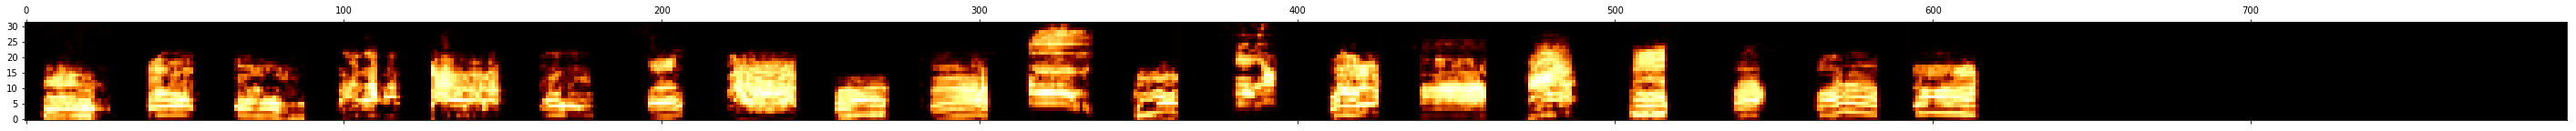

whistle 19
(50.0, 2) (32, 800) 25.0 32 800


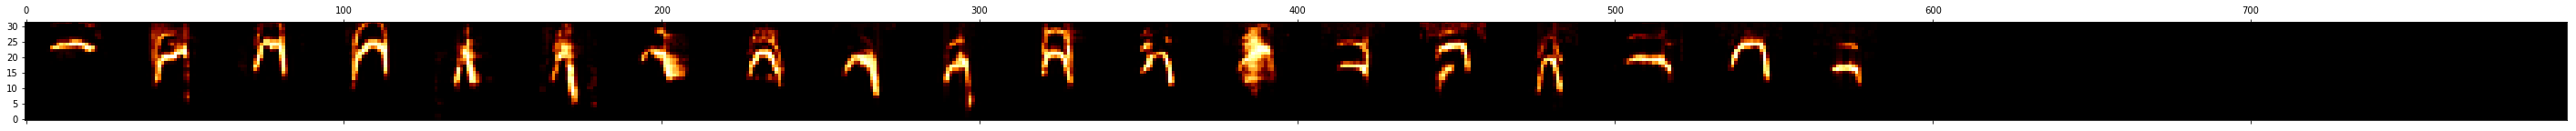

whistle double 13
(50.0, 2) (32, 800) 25.0 32 800


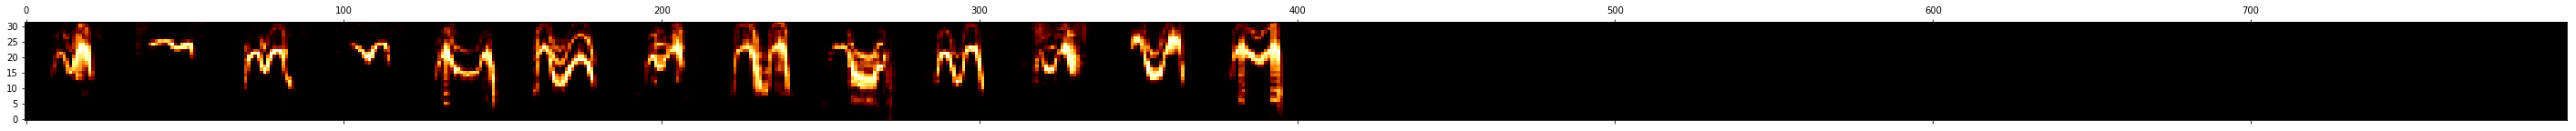

In [87]:
for labels in np.sort(syllable_df.labels.unique()):
    print(labels, np.sum(syllable_df.labels == labels))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.labels == labels].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [101]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'otter.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)